In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [7]:
# Đọc dữ liệu từ tệp Excel
data = pd.read_excel('real_estate_listings.xlsx')


In [8]:
# In ra danh sách các cột để kiểm tra dữ liệu
print("Các cột có trong tập dữ liệu:")
for col in data.columns:
    print(f"- {col}")


Các cột có trong tập dữ liệu:
- Vị trí
- Giá
- Loại nhà
- Diện tích đất
- Số phòng ngủ
- Số toilet
- Tổng số tầng
- Hướng cửa chính
- Hướng ban công
- Giấy tờ pháp lý


In [9]:
# Hàm chuyển đổi giá bất động sản từ chuỗi sang số (đơn vị: tỷ đồng)
def convert_price_to_numeric(price_str):
    if pd.isna(price_str):  # Kiểm tra nếu giá trị bị thiếu
        return np.nan
    
    price_str = str(price_str).strip()  # Chuyển sang chuỗi và loại bỏ khoảng trắng
    
    # Xử lý giá có đơn vị "tỷ"
    if 'tỷ' in price_str:
        match = re.search(r'(\d+(?:[\.,]\d+)?)\s*tỷ(?:\s*(\d+(?:[\.,]\d+)?)\s*triệu)?', price_str)
        if match:
            billions = float(match.group(1).replace(',', '.'))  # Lấy phần "tỷ"
            millions = float(match.group(2).replace(',', '.')) / 1000 if match.group(2) else 0  # Chuyển "triệu" thành "tỷ"
            return billions + millions
    
    # Xử lý giá có đơn vị "triệu"
    elif 'triệu' in price_str:
        match = re.search(r'(\d+(?:[\.,]\d+)?)\s*triệu', price_str)
        if match:
            return float(match.group(1).replace(',', '.')) / 1000  # Chuyển triệu thành tỷ
    
    # Xử lý giá trị đã là số
    try:
        return float(price_str.replace(',', '.'))
    except:
        return np.nan

In [10]:
# Chuyển đổi cột "Giá" thành dạng số nếu có
if 'Giá' in data.columns:
    data['Giá_numeric'] = data['Giá'].apply(convert_price_to_numeric)
else:
    price_columns = [col for col in data.columns if 'giá' in col.lower() or 'gia' in col.lower()]
    if price_columns:
        print(f"Sử dụng cột giá: {price_columns[0]}")
        data['Giá_numeric'] = data[price_columns[0]].apply(convert_price_to_numeric)
    else:
        raise ValueError("Không tìm thấy cột giá trong tập dữ liệu")


In [11]:
# Hàm chuyển đổi diện tích từ chuỗi sang số
def convert_area_to_numeric(area_str):
    if pd.isna(area_str):
        return np.nan
    
    area_str = str(area_str).strip()
    match = re.search(r'(\d+(?:[\.,]\d+)?)', area_str)
    if match:
        return float(match.group(1).replace(',', '.'))
    
    return np.nan

In [12]:
# Tìm các cột có thể chứa diện tích
area_columns = [col for col in data.columns if 'diện tích' in col.lower() or 'dien tich' in col.lower() or 'm²' in str(col).lower()]
print(f"Các cột diện tích được tìm thấy: {area_columns}")

Các cột diện tích được tìm thấy: ['Diện tích đất']


In [13]:
# Chuyển đổi diện tích sang số
for col in area_columns:
    data[f'{col}_numeric'] = data[col].apply(convert_area_to_numeric) if data[col].dtype == 'object' else data[col]

In [14]:
# Tìm các cột liên quan đến số phòng, số toilet, số tầng
room_columns = [col for col in data.columns if any(x in col.lower() for x in ['phòng', 'phong', 'toilet', 'wc', 'tầng', 'tang'])]
print(f"Các cột liên quan đến phòng/toilet/tầng: {room_columns}")

Các cột liên quan đến phòng/toilet/tầng: ['Số phòng ngủ', 'Số toilet', 'Tổng số tầng']


In [15]:
# Xác định các cột số để sử dụng trong mô hình
numeric_columns = ['Giá_numeric'] + [f'{col}_numeric' for col in area_columns]
for col in room_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    if not data[col].isna().all():
        numeric_columns.append(col)

In [16]:
print("Các cột số cuối cùng sẽ được sử dụng trong mô hình:", numeric_columns)


Các cột số cuối cùng sẽ được sử dụng trong mô hình: ['Giá_numeric', 'Diện tích đất_numeric', 'Tổng số tầng']


In [17]:
# Xác định giá trung vị để làm biến mục tiêu
median_price = data['Giá_numeric'].median()
print(f"Giá trung vị: {median_price} tỷ đồng")
data['AboveMedianPrice'] = (data['Giá_numeric'] > median_price).astype(int)

Giá trung vị: 4.66 tỷ đồng


In [18]:
# Chuẩn bị dữ liệu cho mô hình
X = data[numeric_columns].fillna(data[numeric_columns].mean())
y = data['AboveMedianPrice']


In [19]:
# Chuẩn hóa dữ liệu
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


In [20]:
# Chia tập dữ liệu thành tập huấn luyện, kiểm tra và xác thực
from sklearn.model_selection import train_test_split
X_train, X_val_test, y_train, y_val_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [21]:
# Xây dựng mô hình mạng nơ-ron bằng Keras
from keras.models import Sequential
from keras.layers import Dense

input_size = X_train.shape[1]
model = Sequential([
    Dense(32, activation='relu', input_shape=(input_size,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

C:\Users\DELL\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Biên dịch mô hình
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5574 - loss: 0.6868 - val_accuracy: 0.5672 - val_loss: 0.6785
Epoch 2/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5591 - loss: 0.6788 - val_accuracy: 0.5672 - val_loss: 0.6747
Epoch 3/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5559 - loss: 0.6761 - val_accuracy: 0.5669 - val_loss: 0.6714
Epoch 4/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5583 - loss: 0.6717 - val_accuracy: 0.5687 - val_loss: 0.6665
Epoch 5/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5637 - loss: 0.6659 - val_accuracy: 0.6153 - val_loss: 0.6613
Epoch 6/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6019 - loss: 0.6613 - val_accuracy: 0.6163 - val_loss: 0.6554
Epoch 7/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6123 - loss: 0.6537 - val_accuracy: 0.6317 - val_loss: 0.6469
Epoch 8/100
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6213 - loss: 0.6459 - val_accu

In [24]:
# Đánh giá mô hình trên tập kiểm tra
test_accuracy = model.evaluate(X_test, y_test)[1]
print(f"Độ chính xác trên tập kiểm tra: {test_accuracy}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9319 - loss: 0.1425
Độ chính xác trên tập kiểm tra: 0.9324462413787842


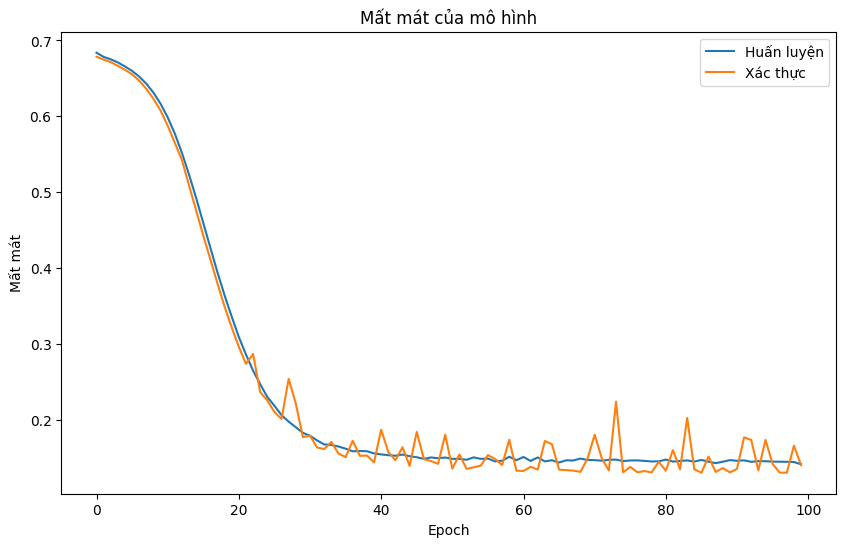

In [25]:
# Vẽ biểu đồ mất mát của mô hình
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Huấn luyện')
plt.plot(history.history['val_loss'], label='Xác thực')
plt.title('Mất mát của mô hình')
plt.xlabel('Epoch')
plt.ylabel('Mất mát')
plt.legend()
plt.show()